In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

# NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Building scenarios with different detector configurations**

We'll begin by defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [4]:
Simulations = 100 # number of simulations
Time = 5 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

Then, we will continue defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [5]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [6]:
# Detection panel span [m]
PanelSpan = 0.7
# PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We can visualise the layout of this in 3D.

#### a) Big gap detection panels

<IPython.core.display.Javascript object>


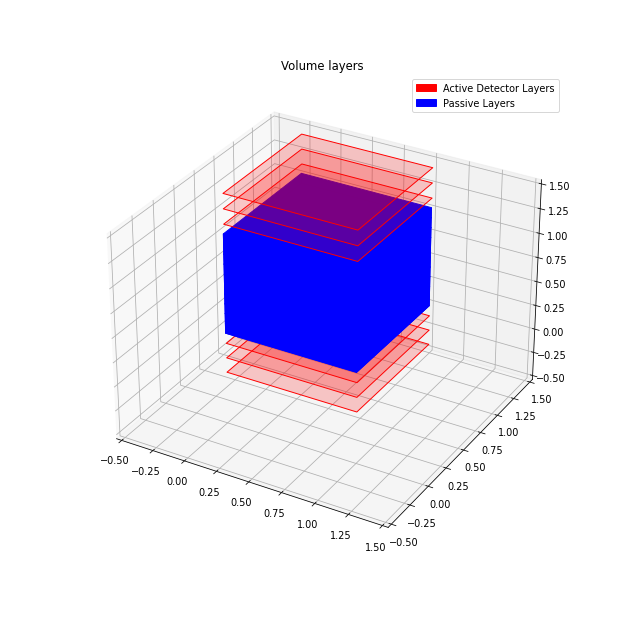

In [7]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### b) Small gap detection panels

<IPython.core.display.Javascript object>


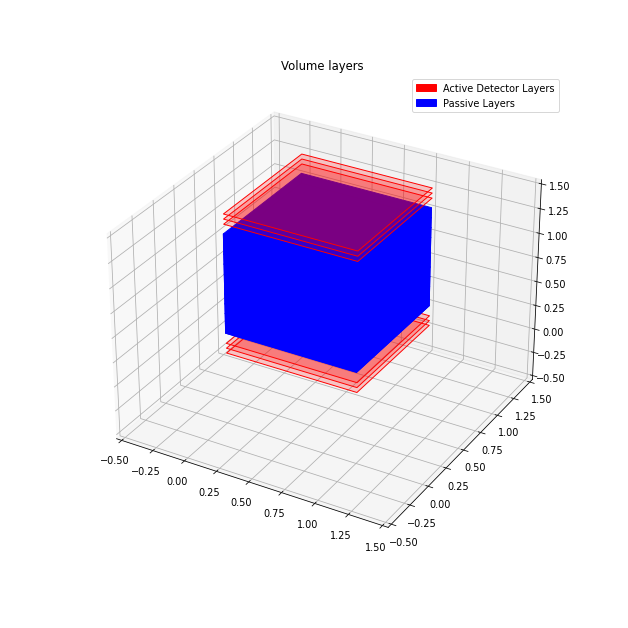

In [8]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### c) Not centred detection panels

<IPython.core.display.Javascript object>


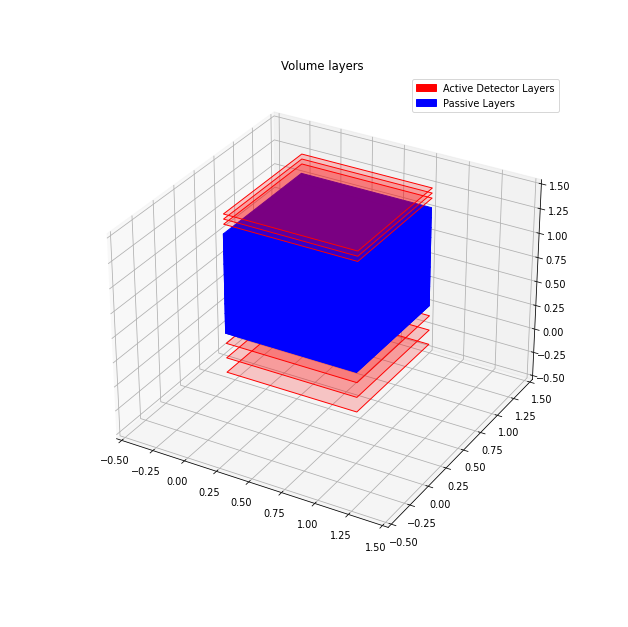

In [9]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [10]:
%matplotlib inline

## **Choose scenario and generate passive volumes**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is made of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [11]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [12]:
# Choose scenario
Scenario = "BigGapHighRes"
Scenario = "BigGap"
# Scenario = "SmallGap"
# Scenario = "NotCentred"

In [13]:
if Scenario=="BigGapHighRes":
    volume=volume_BigGapHighRes
if Scenario=="BigGap":
    volume=volume_BigGap
if Scenario=="SmallGap":
    volume=volume_SmallGap
if Scenario=="NotCentred":
    volume=volume_NotCentred


print(volume)
# volume.get_detectors(), volume.get_passives()

passive_gen = LadleFurnacePassiveGenerator(volume)

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We'll generate 10 volumes at a every fill-height. The 10cm of slag will be present for ever volume.

In [14]:
N_PASSIVES_PER_H = 10
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

from tomopt.optimisation import PassiveYielder

trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

This is the amount of passive volumes generated.

In [15]:
len(trn_passives)

80

Let's visualise one of these volume layouts by repurposing one of the visualisers in TomOpt

In [16]:
SelectedVolume = 10
f,t = trn_passives.passives[SelectedVolume]
volume.load_rad_length(f, t)

In [17]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [18]:
from tomopt.plotting import plot_true_x0, plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [19]:
import numpy as np

In [20]:
type(1/np.sqrt(volume.get_rad_cube()))

torch.Tensor

In [21]:
volume.get_rad_cube()[:,4,4]*100

tensor([1.7820e+00, 1.9910e+00, 1.9910e+00, 1.9910e+00, 8.2110e+00, 3.0390e+04,
        3.0390e+04, 3.0390e+04, 3.0390e+04, 3.0390e+04])

true


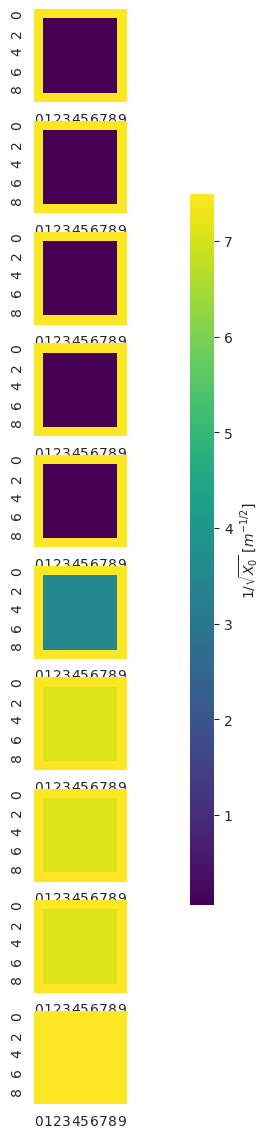

In [22]:
%matplotlib inline
# plot_pred_true_x0(pred=1/np.sqrt(volume.get_rad_cube()), true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X0} \ [cm^{-1/2}]$')
plot_pred_true_x0(true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X_0} \ [m^{-1/2}]$')


In the plot of the cell above the layers of the ladle can be observed, coloured depending on the X0 of the voxel material:

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

The inverse of the square root of X0 has been plotted, a value which is approximately linear to the material density. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Muon generation and propagation**


In [23]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [24]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [25]:
from tomopt.muon import MuonBatch

In [26]:
muons = MuonBatch(gen(2000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.3289), muons.y[0]=tensor(0.8834), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.4856)'

In [27]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.4956), muons.y[0]=tensor(1.8187), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.4856)'

In [28]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 0.3307,  0.8849,  1.8000],
           [ 0.3427,  0.9603,  1.6500],
           [ 0.3573,  1.0404,  1.5000]],
  
          [[ 1.3489,  1.1616,  1.8000],
           [ 7.3994,  1.2375,  1.6500],
           [ 1.5193,  1.1844,  1.5000]],
  
          [[ 1.3517,  0.5795,  1.8000],
           [ 1.8209,  0.6575,  1.6500],
           [ 1.2576,  0.7367,  1.5000]],
  
          ...,
  
          [[ 0.7601, -0.3781,  1.8000],
           [ 0.8124, -0.7455,  1.6500],
           [ 0.8658, -0.2558,  1.5000]],
  
          [[ 0.1180,  0.3705,  1.8000],
           [ 0.0672,  0.4157,  1.6500],
           [ 0.0190,  0.4625,  1.5000]],
  
          [[ 0.6270,  0.8805,  1.8000],
           [ 0.6530,  1.0296,  1.6500],
           [ 0.6806,  1.1657,  1.5000]]], grad_fn=<StackBackward0>),
  'gen_xyz': tensor([[[ 0.3289,  0.8834,  1.8000],
           [ 0.3428,  0.9613,  1.6500],
           [ 0.3567,  1.0392,  1.5000]],
  
          [[ 1.3516,  1.1621,  1.8000],
           [ 1.43

In [29]:
hits['above']['reco_xyz'].shape  # (muons, detector layer, xy)

torch.Size([2000, 3, 3])

In [30]:
from tomopt.inference import ScatterBatch

In [31]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 182 ms, sys: 4.59 ms, total: 187 ms
Wall time: 365 ms


In [32]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 43.4 s, sys: 27.2 s, total: 1min 10s
Wall time: 39.7 s


(tensor([[ 0.3879,  1.2143,  1.1645],
         [ 2.1487,  1.2725,  0.3928],
         [ 0.8714,  1.3818,  0.2656],
         ...,
         [ 0.8255, -0.3079,  1.6232],
         [-0.2318,  0.6922,  0.7437],
         [ 0.8591,  2.1409,  0.4776]], grad_fn=<AddBackward0>),
 tensor([[0.5076, 2.9252, 5.6604],
         [0.1128, 0.0187, 0.2195],
         [0.2899, 0.4611, 0.8880],
         ...,
         [0.3133, 0.3609, 0.8821],
         [0.1925, 0.1808, 0.5939],
         [0.0743, 0.4081, 0.4328]], grad_fn=<SqrtBackward0>))

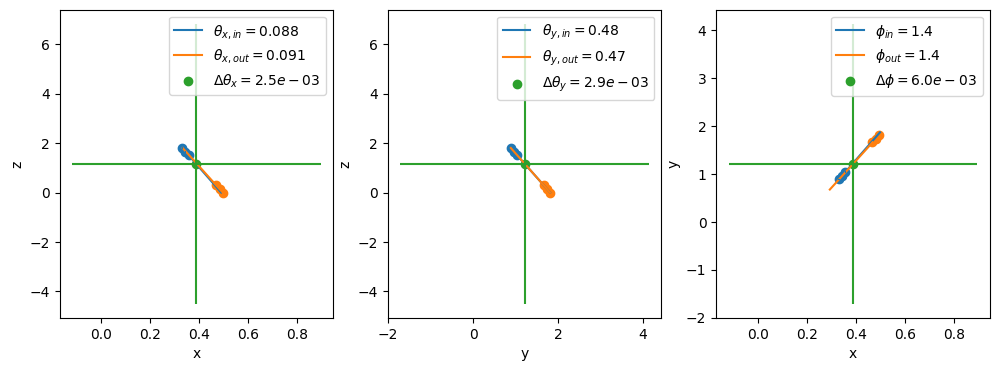

In [33]:
sb.plot_scatter(idx=0)

## **Inference example**
####  Assuming that POCA distribution centre in Z indicates the centre of steel volume

In [40]:
import matplotlib.pyplot as plt

In [41]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 7.0870, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.30000000000000004

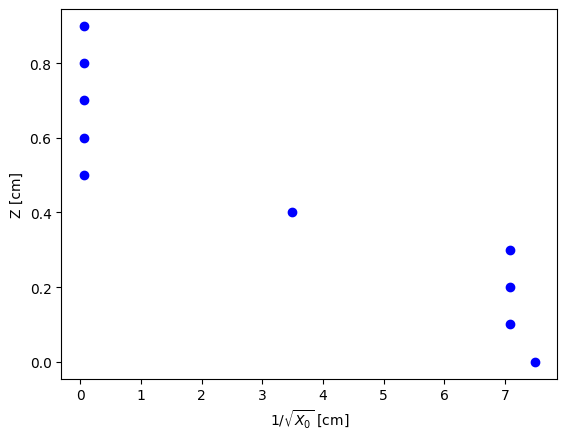

In [42]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [43]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.3252


In [44]:
sb.poca_xyz.detach().cpu().numpy()[:, 0].shape

(1999,)

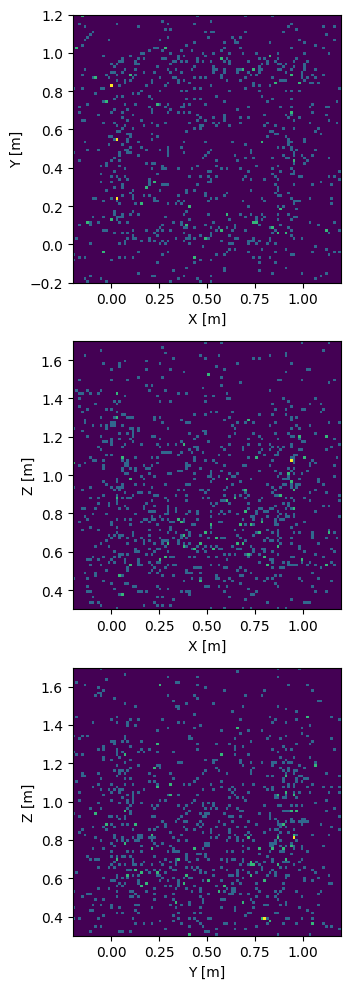

In [45]:
sb.plot_poca_batch(Zlims=[0.5-0.2, 1.5+0.2])

In [46]:
PocaZ

array([1.1645058 , 0.39275286, 0.26555464, ..., 1.6232139 , 0.7436782 ,
       0.47755015], dtype=float32)

#### All POCA

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.2252


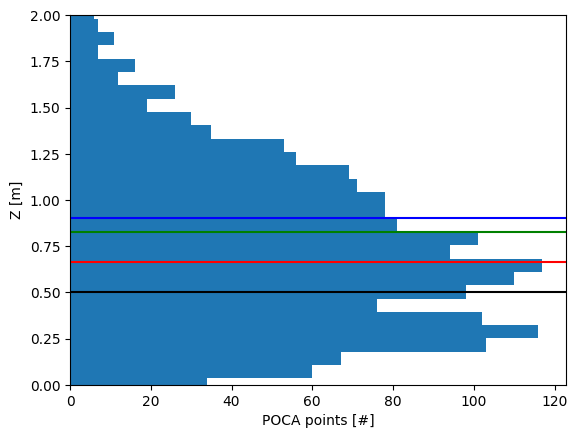

In [47]:
%matplotlib inline

FurnaceBottom = 0.5
BottomWallThickness = 0.1

PocaZ = sb.poca_xyz[:, 2].detach().numpy()

SteelLevel_Pred = (np.mean(PocaZ)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(PocaZ), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(PocaZ, bins=200, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()


#### POCA within furnace XY walls

In [48]:
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)


Actual steel level [m]: 0.3
Predicted steel level [m]: 0.5548


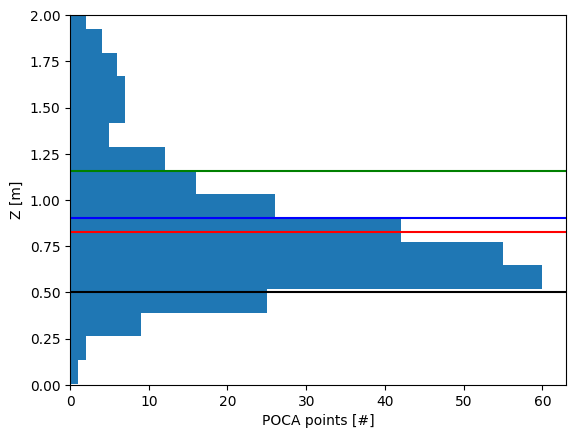

In [49]:
%matplotlib inline

Poca_z = sb.poca_xyz[:, 2].detach().numpy()
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

# Select POCA points within XY furnace walls
f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
f = f_x & f_y

Poca_z = Poca_z[f]

SteelLevel_Pred = (np.mean(Poca_z)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(Poca_z), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(Poca_z, bins=50, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()

# Run multiple simulations and get POCA mean, as well as true steel level

### Generation

In [51]:
GeneratedMuons = 10000
muons = MuonBatch(gen(10000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.3846), muons.y[0]=tensor(1.2173), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.2169)'

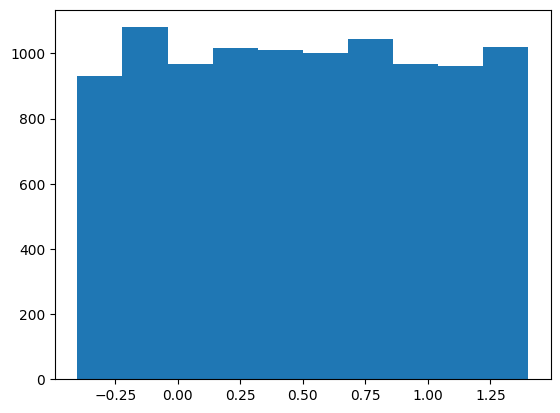

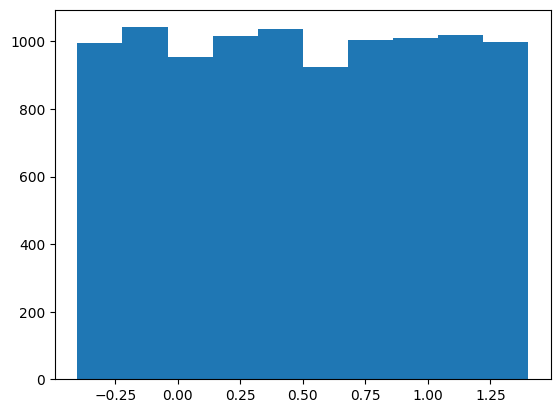

2.25

In [52]:
plt.hist(muons.x)
plt.show()

plt.hist(muons.y)
plt.show()

# Generation surface of 1.5x1.5 m²

1.5*1.5

In [54]:
import sys

def ProgBar(percent, bar_length = 30):  # bar_length should be less than 100
    sys.stdout.write('\r')
    sys.stdout.write("Completed: [{:{}}] {:>3}%"
                     .format('='*int(percent/(100.0/bar_length)),
                             bar_length, int(percent)))
    sys.stdout.flush()

In [56]:
TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

Poca_z_means = np.zeros(len(trn_passives.passives))
Poca_z_means[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    ProgBar(percent=100.0*i/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    Poca_z = sb.poca_xyz[:, 2].detach().numpy()

    # within XY furnace walls
    # Poca_x = sb.poca_xyz[:, 0].detach().numpy()
    # Poca_y = sb.poca_xyz[:, 1].detach().numpy()

    # Select POCA points within XY furnace walls
    # f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
    # f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
    # f = f_x & f_y
    
    # Poca_z = Poca_z[f]
    
    Poca_z_mean = np.mean(Poca_z)


    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    
    TrueSteelLevels[i] = SteelLevel_True
    Poca_z_means[i] = Poca_z_mean
    


Completed: [============================= ]  98%

In [59]:
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_TrueSteelLevels.csv", TrueSteelLevels)
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_PocaZmeans.csv", Poca_z_means)


In [60]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_TrueSteelLevels.csv")
Poca_z_means = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_PocaZmeans.csv")


In [61]:
LevelMeans = np.array(np.unique(TrueSteelLevels))

for i in range(len(np.unique(TrueSteelLevels))):
    SteelLevel = np.unique(TrueSteelLevels)[i]
    LevelMeans[i] = np.mean(Poca_z_means[TrueSteelLevels==SteelLevel])

LevelMeans

array([0.61537729, 0.62765157, 0.62453599, 0.64984254, 0.65625219,
       0.65286039, 0.64919181, 0.69301029])

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

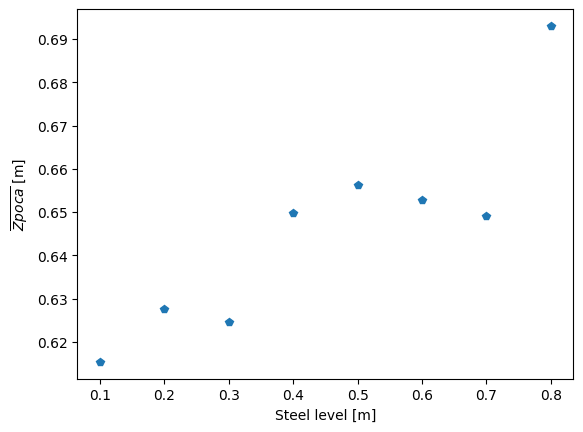

In [62]:
plt.plot(np.unique(TrueSteelLevels), LevelMeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

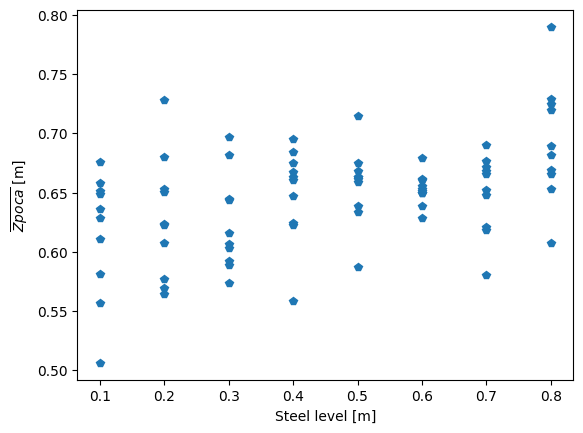

In [64]:
plt.plot(TrueSteelLevels, Poca_z_means, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

(array([  2.,   6.,  60., 188., 961., 641., 117.,  18.,   4.,   2.]),
 array([-5.36966991, -4.14682579, -2.9239819 , -1.70113802, -0.47829399,
         0.74454999,  1.96739399,  3.190238  ,  4.41308212,  5.63592577,
         6.85876989]),
 <BarContainer object of 10 artists>)

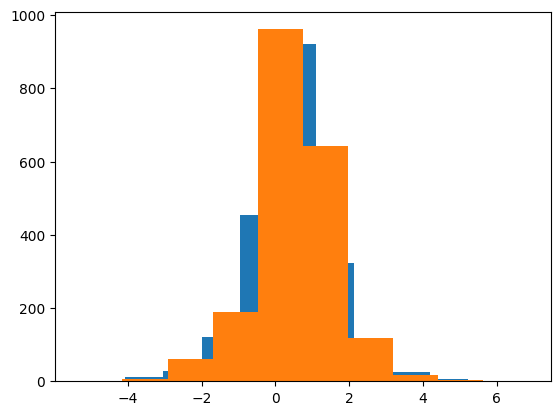

In [66]:
plt.hist(Poca_x)
plt.hist(Poca_y)


#### POCA within furnace XY walls

In [67]:
TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

Poca_z_means = np.zeros(len(trn_passives.passives))
Poca_z_means[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    ProgBar(percent=100.0*i/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    Poca_z = sb.poca_xyz[:, 2].detach().numpy()

    # within XY furnace walls
    Poca_x = sb.poca_xyz[:, 0].detach().numpy()
    Poca_y = sb.poca_xyz[:, 1].detach().numpy()

    # Select POCA points within XY furnace walls
    f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
    f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
    f = f_x & f_y
    
    Poca_z = Poca_z[f]
    
    Poca_z_mean = np.mean(Poca_z)


    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    
    TrueSteelLevels[i] = SteelLevel_True
    Poca_z_means[i] = Poca_z_mean

Completed: [============================= ]  98%

In [68]:
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_TrueSteelLevels.csv", TrueSteelLevels)
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_PocaZmeans.csv", Poca_z_means)

In [69]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_TrueSteelLevels.csv")
Poca_z_means = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_PocaZmeans.csv")

In [70]:
LevelMeans = np.array(np.unique(TrueSteelLevels))


for i in range(len(np.unique(TrueSteelLevels))):
    SteelLevel = np.unique(TrueSteelLevels)[i]
    LevelMeans[i] = np.mean(Poca_z_means[TrueSteelLevels==SteelLevel])

LevelMeans

array([0.8027329 , 0.81001428, 0.84521541, 0.85544266, 0.87179495,
       0.8977412 , 0.95011074, 0.99187511])

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

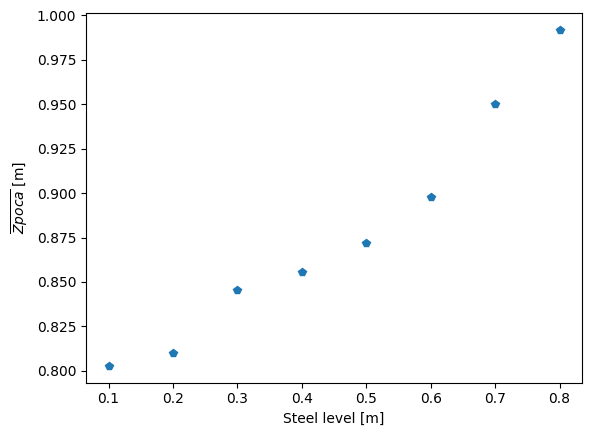

In [71]:
plt.plot(np.unique(TrueSteelLevels), LevelMeans, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")

(array([18., 25., 18., 12., 16., 16., 17., 10., 11., 16.]),
 array([0.10044067, 0.179221  , 0.25800136, 0.33678168, 0.415562  ,
        0.49434236, 0.57312268, 0.65190303, 0.73068339, 0.80946368,
        0.88824403]),
 <BarContainer object of 10 artists>)

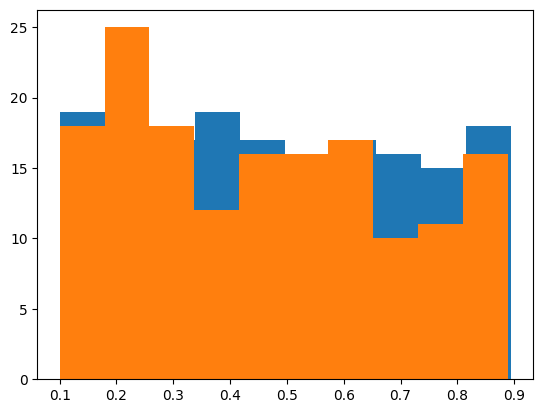

In [94]:
plt.hist(Poca_x[f])
plt.hist(Poca_y[f])